In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt

import seaborn as sns

from tqdm import tqdm

from src.utils import create_stats_df, plot_stats_histogram, plot_performance_frs, calculate_statistics, plot_histogram, plot_frs_histogram

from statsmodels.stats.proportion import proportions_ztest

# make the default font size point 7
plt.rcParams.update({"font.size": 7})

%load_ext autoreload
%autoreload 2

## Load datasets

First let's load the predicted effects for those in *rpoB* (which is the only gene in the WHOv2 catalogue that confers resistance to RIF). This will let us identify all the definite resistance-associated variants. (If we used the WHOv2 catalogue we'd have to unpack and deal with generic rules which is harder).

In [2]:
effects = pd.read_csv('data/RIF_EFFECTS.csv.gz')

resistance_mutations = effects.GENE_MUTATION.unique()

print(f"There are {len(resistance_mutations)} unique resistance mutations according to WHOv2 in our dataset")

print(f"These include {resistance_mutations[:3]}")

There are 127 unique resistance mutations according to WHOv2 in our dataset
These include ['rpoB_S450L' 'rpoB_V170F' 'rpoB_H445Y']


In [3]:
effects.to_csv('data/RIF_EFFECTS.csv', index = False)

We will get our list of compensatory mutations from this paper

> Brunner V, Fowler PW
>
> Compensatory mutations are associated with increased in vitro growth in resistant clinical samples of *Mycobacterium tuberculosis*.
>
> mGen 10:001187 doi:10.1099/mgen.0.001187

The list is publicly available from here:

https://github.com/fowler-lab/tb-rnap-compensation

In [4]:
CMs = pd.read_csv('data/final_CM_hit_list.csv')
CMs = CMs[CMs.homoplasy == True]
compensatory_mutations = CMs['putative CM'].unique()

print(f"There are {len(compensatory_mutations)} compensatory mutations in the RNAP identified by this study")
print(f"These include {compensatory_mutations[:3]}")

There are 51 compensatory mutations in the RNAP identified by this study
These include ['rpoC_V483G' 'rpoC_I491V' 'rpoC_V483A']


### Drug susceptibility measurements

Let's load in these; one problem we will have to solve is that some samples have more than one rifampicin measurement. For example, they could have an MIC from a UKMYC6 96-well broth microdilution plate but they could also have an R/S from a MGIT960 tube. The approach we will take is to classify any samples as resistant if any of their DST results indicate resistance and we will keep, by preference, the UKMYC measurements since we have more detailed information on these.

In [5]:
phenotypes = pd.read_csv('data/RIF_PHENOTYPES.csv.gz')

agg_phenotypes = phenotypes[['UNIQUEID', 'DRUG']].groupby(['UNIQUEID']).count()
agg_phenotypes.value_counts(dropna=False)

multiples = agg_phenotypes[agg_phenotypes.DRUG>1].index
singles = agg_phenotypes[agg_phenotypes.DRUG==1].index

print(f"There are {len(singles) + len(multiples)} samples with at least one RIF DST measurement.")
print(f"Of these {len(singles)} samples have a single DST measurement and {len(multiples)} have multiple DST measurements.")

phenotypes.set_index('UNIQUEID', inplace = True)
phenotypes[:3]

There are 52148 samples with at least one RIF DST measurement.
Of these 43150 samples have a single DST measurement and 8998 have multiple DST measurements.


,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,QUALITY
UNIQUEID,,,,,,,,,
site.24.subj.PT-2.lab.1997-606.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM
site.24.subj.PT-4.lab.1998-151.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM
site.24.subj.PT-5.lab.1998-713.iso.1,RIF,SEQTREAT2020,liquid media,MGIT,BACTEC460,1.0,NaN,S,MEDIUM


In [6]:
# go through the list of UNIQUEIDs with multiple RIF DST measurements and apply the logic described above

table = []
for uid in tqdm(multiples):

    phenotype=None
    first_row=True
    for idx,row in phenotypes.loc[uid].iterrows():

        # if this is the first entry, just add it
        if first_row:

            table.append(row)
            phenotype=row.PHENOTYPE
            method=row.METHOD_3
            first_row=False

        else:   

            # but if the new phenotype is resistant, add the row
            if phenotype=='S' and row.PHENOTYPE == 'R':
                table[-1] = row

            # or replace with the UKMYC result if the phenotypes are the same 
            elif phenotype==row.PHENOTYPE and row.METHOD_3 in ['UKMYC5', 'UKMYC6']:
                table[-1] = row

phenotypes = pd.concat([phenotypes.loc[singles], pd.DataFrame(table)])
assert phenotypes.index.duplicated().sum()==0, 'there are still duplicates in the table'
phenotypes.index.name = 'UNIQUEID'
phenotypes = phenotypes[phenotypes.PHENOTYPE.isin(['S', 'R'])]
print(f"We have {len(phenotypes)} samples with a definite (R/S) DST measurement for RIF")

phenotypes = phenotypes[phenotypes.QUALITY!='LOW']
print(f"Removing samples where there is disagreement about the phenotype leaves {len(phenotypes)} samples")

phenotypes[:3]

100%|██████████| 8998/8998 [00:07<00:00, 1177.71it/s]


We have 51183 samples with a definite (R/S) DST measurement for RIF
Removing samples where there is disagreement about the phenotype leaves 48031 samples


,DRUG,SOURCE,METHOD_1,METHOD_2,METHOD_3,METHOD_CC,METHOD_MIC,PHENOTYPE,QUALITY
UNIQUEID,,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,NaN,NaN,R,MEDIUM
site.00.subj.1000595.lab.H123460044.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,NaN,NaN,R,MEDIUM
site.00.subj.1004213.lab.H111060034.iso.1,RIF,NEJM2018,solid media,LJ,resistance ratio,NaN,NaN,R,MEDIUM


### Genetics

Since not all samples with DST measurements have also been whole-genome sequenced, and of those, not all have mutations in the RNA polymerase we have to (i) first subset down to those samples with WGS data and then (ii) consider those samples with mutations in the RNAP.


In [8]:
genomes = pd.read_csv('data/GENOMES.csv.gz')
genomes.set_index('UNIQUEID', inplace = True)
samples = phenotypes[['PHENOTYPE']][phenotypes.index.isin(genomes.index)]
print(f"We have {len(samples)} samples with both a definite DST measurement for RIF and a whole genome")
samples[:3]

We have 30459 samples with both a definite DST measurement for RIF and a whole genome


,PHENOTYPE
UNIQUEID,
site.00.subj.1000347.lab.H111540004.iso.1,R
site.00.subj.1000595.lab.H123460044.iso.1,R
site.00.subj.1004213.lab.H111060034.iso.1,R


Now load all the mutations in the RNA polymerase and identify which mutations are associated with resistance and which have been identified as compensatory

In [9]:
mutations = pd.read_csv('data/RNAP_MUTATIONS.csv.gz')

# add resistance and compensatory mutation flags to mutations table: 
#  need to check for minor allele before concatenating GENE_MUTATION 
mutations['GENE_MUTATION'] = np.where(
    mutations['IS_MINOR_ALLELE'],  # Condition: if IS_MINOR_ALLELE is True
    mutations['GENE'].astype(str) + '_' + mutations['MINOR_MUTATION'].astype(str),  # Then: use GENE + MINOR_MUTATION
    mutations['GENE'].astype(str) + '_' + mutations['MUTATION'].astype(str)  # Else: use GENE + MUTATION
)

# all the homogenous mutations have an FRS of NaN so set to unity for now
mutations.loc[~mutations.IS_MINOR_ALLELE, 'FRS'] = 1

mutations['IS_RESISTANT_MUTATION'] = mutations['GENE_MUTATION'].isin(resistance_mutations)
mutations['IS_COMPENSATORY_MUTATION'] = mutations['GENE_MUTATION'].isin(compensatory_mutations)
mutations.set_index('UNIQUEID', inplace=True)

mutations = mutations[mutations.index.isin(samples.index)]

print(f"There are {len(mutations)} RNAP mutations in {len(mutations.index.unique())} samples that have been whole genome sequenced in our dataset")
mutations[:3]

There are 101079 RNAP mutations in 27367 samples that have been whole genome sequenced in our dataset


,GENE,MUTATION,REF,ALT,NUCLEOTIDE_NUMBER,NUCLEOTIDE_INDEX,GENE_POSITION,CODES_PROTEIN,INDEL_LENGTH,INDEL_NUCLEOTIDES,AMINO_ACID_NUMBER,AMINO_ACID_SEQUENCE,NUMBER_NUCLEOTIDE_CHANGES,IS_MINOR_ALLELE,MINOR_MUTATION,FRS,GENE_MUTATION,IS_RESISTANT_MUTATION,IS_COMPENSATORY_MUTATION
UNIQUEID,,,,,,,,,,,,,,,,,,,
site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,1.0,rpoB_S450L,True,False
site.01.subj.DR0682.lab.DR0682.iso.1,rpoB,A1075A,gct,gcc,NaN,NaN,1075.0,True,NaN,NaN,1075.0,A,1.0,False,NaN,1.0,rpoB_A1075A,False,False
site.01.subj.DR0134.lab.DR0134.iso.1,rpoB,S450L,tcg,ttg,NaN,NaN,450.0,True,NaN,NaN,450.0,L,1.0,False,NaN,1.0,rpoB_S450L,True,False


In [10]:
# aggregate mutations by UNIQUEID and keep columns of interest: define FRS to be the maximum of any resistant mutations, otherwise the maximum of the remaining mutations

def aggregate_minor_major_allele(group):

    # Check if any row has both IS_MINOR_ALLELE and RESISTANT_MUTATION
    minor_allele_flag = any((group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION']))
    major_allele_flag = any((~group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION']))

    resistant_major_allele_rows = group[(~group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION'])]

    # Get the rows where there is a resistant minor allele
    resistant_minor_allele_rows = group[(group['IS_MINOR_ALLELE']) & (group['IS_RESISTANT_MUTATION'])]
    
    resistant_allele_rows = group[(group['IS_RESISTANT_MUTATION'])]

    if resistant_major_allele_rows.empty:

        if not resistant_minor_allele_rows.empty:

            # If there are resistant minor alleles, get the maximum FRS value for those rows
            frs_value = resistant_minor_allele_rows['FRS'].max()

        else:

            # Otherwise, use the maximum FRS value from the remaining non-resistant mutations
            frs_value = group['FRS'].max()

    else:

        frs_value = resistant_major_allele_rows['FRS'].max()
    
    return pd.Series({
        'HAS_RNAP_MUTATIONS': True,
        'HAS_RESISTANT_MUTATION': group['IS_RESISTANT_MUTATION'].max(),
        'HAS_COMPENSATORY_MUTATION': group['IS_COMPENSATORY_MUTATION'].max(),
        'HAS_R_MINOR_ALLELE': minor_allele_flag,
        'HAS_R_MAJOR_ALLELE': major_allele_flag,
        'FRS': frs_value,  # Use the maximum FRS for resistant minor alleles, if present
    })

# Apply the custom aggregation function
agg_mutations = mutations.groupby('UNIQUEID').apply(aggregate_minor_major_allele).reset_index()
agg_mutations.set_index('UNIQUEID', inplace=True)
agg_mutations[:3]

,HAS_RNAP_MUTATIONS,HAS_RESISTANT_MUTATION,HAS_COMPENSATORY_MUTATION,HAS_R_MINOR_ALLELE,HAS_R_MAJOR_ALLELE,FRS
UNIQUEID,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,True,True,False,False,True,1.0
site.00.subj.1000595.lab.H123460044.iso.1,True,True,True,False,True,1.0
site.00.subj.1004213.lab.H111060034.iso.1,True,True,True,False,True,1.0


Now we can join the information on the samples which have RNAP mutations to the table of samples with a DST result and a whole genome. We will need to fill in the gaps for those samples which do not have any RNAP mutations.

In [11]:
samples = samples.join(agg_mutations, how='left')

samples.loc[samples.HAS_COMPENSATORY_MUTATION.isna(), 'HAS_RNAP_MUTATIONS'] = False
samples.loc[samples.HAS_COMPENSATORY_MUTATION.isna(), 'HAS_RESISTANT_MUTATION'] = False
samples.loc[samples.HAS_COMPENSATORY_MUTATION.isna(), 'HAS_R_MINOR_ALLELE'] = False
samples.loc[samples.HAS_COMPENSATORY_MUTATION.isna(), 'HAS_R_MAJOR_ALLELE'] = False
samples.loc[samples.HAS_COMPENSATORY_MUTATION.isna(), 'HAS_COMPENSATORY_MUTATION'] = False

samples['IS_RESISTANT'] = samples.PHENOTYPE == 'R'

# because we did a left join and hence there were a lot of NaNs to fill in, we need to force these columns to be boolean
for i in ['HAS_RNAP_MUTATIONS', 'HAS_COMPENSATORY_MUTATION', 'HAS_RESISTANT_MUTATION', 'HAS_R_MINOR_ALLELE', 'HAS_R_MAJOR_ALLELE']:
    samples[i] = samples[i].astype(bool)

samples[:3]

,PHENOTYPE,HAS_RNAP_MUTATIONS,HAS_RESISTANT_MUTATION,HAS_COMPENSATORY_MUTATION,HAS_R_MINOR_ALLELE,HAS_R_MAJOR_ALLELE,FRS,IS_RESISTANT
UNIQUEID,,,,,,,,
site.00.subj.1000347.lab.H111540004.iso.1,R,True,True,False,False,True,1.0,True
site.00.subj.1000595.lab.H123460044.iso.1,R,True,True,True,False,True,1.0,True
site.00.subj.1004213.lab.H111060034.iso.1,R,True,True,True,False,True,1.0,True


In [12]:
print(f"We have {len(samples)} samples with a definite DST measurement for RIF and a genome\n")

print(f"Of these {samples.HAS_RNAP_MUTATIONS.sum()} have one or more mutations in the RNAP\n")

print(f"As you might expect nearly all of the samples with no RNAP mutations test as susceptible to RIF:")
print(pd.crosstab(samples.HAS_RNAP_MUTATIONS, samples.IS_RESISTANT))


We have 30459 samples with a definite DST measurement for RIF and a genome

Of these 27367 have one or more mutations in the RNAP

As you might expect nearly all of the samples with no RNAP mutations test as susceptible to RIF:
IS_RESISTANT        False  True 
HAS_RNAP_MUTATIONS              
False                3031     61
True                17344  10023


In [13]:
a = copy.deepcopy(samples[samples.FRS>0])


In [14]:
def calculate_results_row(df, description=None, min_FRS=None):
    true_positives = int(df[(df["IS_RESISTANT"]) & (df["HAS_RESISTANT_MUTATION"])].shape[0])
    positives = int(df[df["IS_RESISTANT"]].shape[0])
    false_positives = int(df[(~df["IS_RESISTANT"]) & (df["HAS_RESISTANT_MUTATION"])].shape[0])

    true_negatives = int(df[(~df["IS_RESISTANT"]) & (~df["HAS_RESISTANT_MUTATION"])].shape[0])
    negatives = int(df[~df["IS_RESISTANT"]].shape[0])
    false_negatives = int(df[(df["IS_RESISTANT"]) & (~df["HAS_RESISTANT_MUTATION"])].shape[0])

    sensitivity = true_positives / positives
    specificity = true_negatives / negatives
    ppv = true_positives / (true_positives + false_positives)
    npv = true_negatives / (true_negatives + false_negatives)

    return (pd.Series([description, min_FRS, true_positives, false_positives, positives, true_negatives, false_negatives, negatives, sensitivity, specificity, ppv, npv], index=["description", "min_FRS", "TP", "FP", "P", "TN", "FN", "N", "sensitivity", "specificity", "PPV", "NPV"]))
    


In [15]:
samples.FRS.value_counts(dropna=False).sort_index()

FRS
0.020        1
0.052        1
0.059        1
0.069        1
0.087        1
         ...  
0.894        1
0.897        2
0.898        1
1.000    26977
NaN       3092
Name: count, Length: 289, dtype: int64

In [16]:
print(f"There are {samples.HAS_RESISTANT_MUTATION.sum()} samples with a RIF resistance-conferring mutation in the RNAP, at any level of read support")

print(f"Of these {samples[samples.HAS_RESISTANT_MUTATION & samples.HAS_R_MAJOR_ALLELE].shape[0]} samples have a homogeneous RAV whilst {samples[samples.HAS_RESISTANT_MUTATION & ~samples.HAS_R_MAJOR_ALLELE & samples.HAS_R_MINOR_ALLELE].shape[0]} have a minor RAV")

There are 10249 samples with a RIF resistance-conferring mutation in the RNAP, at any level of read support
Of these 9986 samples have a homogeneous RAV whilst 263 have a minor RAV


Here minor RAV means any variant with less than 90% read support; so what is the distribution? Do they all have just a bit less than 90%?

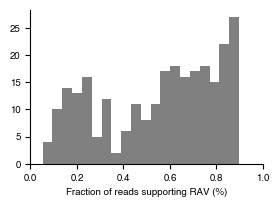

In [17]:
df = samples[(samples.HAS_RESISTANT_MUTATION) & (samples.FRS<1) & (samples.FRS>0.05)]
plot_frs_histogram(df, savefig=True)

Let's therefore change the definition of what is a resistance associated variant by altering the FRS which leads to it being classified and therefore predicting resistance.

We will store the results in a `pandas.DataFrame` so we can later plot graphs etc.

In [18]:
for i in range(0, 100, 5):
    cutoff = i / 100
    df = samples.copy() 
    df['HAS_RESISTANT_MUTATION'] = ((df['FRS'] >= cutoff) & (df.HAS_R_MINOR_ALLELE)) | (df.HAS_R_MAJOR_ALLELE)
    a = calculate_results_row(df, description='scan FRS', min_FRS=cutoff)
    if i == 0:
        results_table = pd.DataFrame(a).T
    else:
        results_table = pd.concat([results_table,pd.DataFrame(a).T])

results_table

,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV
0,scan FRS,0.0,9739,510,10084,19865,345,20375,0.965787,0.974969,0.950239,0.982929
0,scan FRS,0.05,9739,510,10084,19865,345,20375,0.965787,0.974969,0.950239,0.982929
0,scan FRS,0.1,9737,508,10084,19867,347,20375,0.965589,0.975067,0.950415,0.982834
0,scan FRS,0.15,9725,505,10084,19870,359,20375,0.964399,0.975215,0.950635,0.982253
0,scan FRS,0.2,9714,502,10084,19873,370,20375,0.963308,0.975362,0.950861,0.981722
0,scan FRS,0.25,9703,495,10084,19880,381,20375,0.962217,0.975706,0.951461,0.981195
0,scan FRS,0.3,9694,494,10084,19881,390,20375,0.961325,0.975755,0.951512,0.980761
0,scan FRS,0.35,9686,489,10084,19886,398,20375,0.960532,0.976,0.951941,0.980379
0,scan FRS,0.4,9684,489,10084,19886,400,20375,0.960333,0.976,0.951932,0.980282
0,scan FRS,0.45,9673,488,10084,19887,411,20375,0.959242,0.976049,0.951973,0.979752


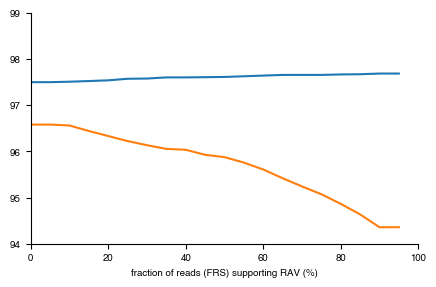

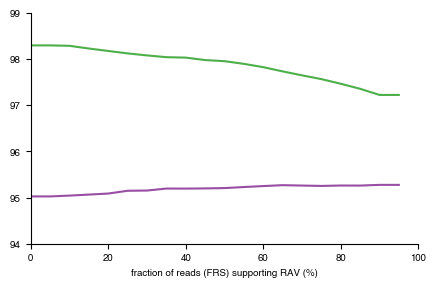

In [19]:
# plot the performance as we alter the minimum FRS

df = results_table.copy()
df = df[df.description=='scan FRS']

plot_performance_frs(df, save_figure=True, metrics=['sensitivity', 'specificity'], colours=["#ff7f0e", "#1f77b4"], save_name='fig-frs-sensitivity-specificity')
plot_performance_frs(df, save_figure=True, metrics=['PPV', 'NPV'], colours=['#984ea3', '#4daf4a'], save_name='fig-frs-ppv-npv')

Since sensitivity appears to rise let's compare two cases so we can do statistics

In [20]:
df = copy.deepcopy(samples)
df['HAS_RESISTANT_MUTATION'] = ((df['FRS'] >= 0.05) & (df.HAS_R_MINOR_ALLELE)) | (df.HAS_R_MAJOR_ALLELE)
a = calculate_results_row(df, description='bar chart', min_FRS=0.05)
results_table = pd.concat([results_table,pd.DataFrame(a).T])

samples_major_only = samples.copy()
samples_major_only['HAS_RESISTANT_MUTATION'] = samples_major_only['HAS_R_MAJOR_ALLELE']
b=calculate_results_row(samples_major_only, description='bar chart', min_FRS=0.90)
results_table = pd.concat([results_table,pd.DataFrame(b).T])
results_table = results_table.sort_values('min_FRS', ascending=False)
results_table


,description,min_FRS,TP,FP,P,TN,FN,N,sensitivity,specificity,PPV,NPV
0,scan FRS,0.95,9515,472,10084,19903,569,20375,0.943574,0.976834,0.952739,0.972206
0,bar chart,0.9,9515,471,10084,19904,569,20375,0.943574,0.976883,0.952834,0.972207
0,scan FRS,0.9,9515,472,10084,19903,569,20375,0.943574,0.976834,0.952739,0.972206
0,scan FRS,0.85,9543,475,10084,19900,541,20375,0.946351,0.976687,0.952585,0.973534
0,scan FRS,0.8,9566,476,10084,19899,518,20375,0.948631,0.976638,0.952599,0.974629
0,scan FRS,0.75,9587,478,10084,19897,497,20375,0.950714,0.97654,0.952509,0.97563
0,scan FRS,0.7,9604,478,10084,19897,480,20375,0.9524,0.97654,0.952589,0.976444
0,scan FRS,0.65,9622,478,10084,19897,462,20375,0.954185,0.97654,0.952673,0.977307
0,scan FRS,0.6,9641,481,10084,19894,443,20375,0.956069,0.976393,0.95248,0.978217
0,scan FRS,0.55,9656,484,10084,19891,428,20375,0.957557,0.976245,0.952268,0.978936


sensitivity -7.583083759809194 3.374368441146938e-14


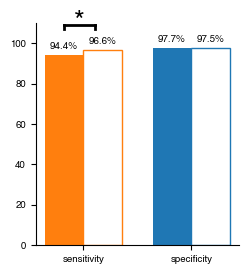

NPV -7.296398557265616 2.955725061567071e-13


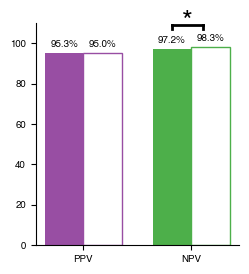

In [21]:
df = results_table[results_table.description=='bar chart']

plot_histogram(df, save_figure=True, metrics=['sensitivity', 'specificity'], colours=["#ff7f0e", "#1f77b4"], save_name='bar-sens-spec')
plot_histogram(df, save_figure=True, metrics=['PPV', 'NPV'], colours=['#984ea3', '#4daf4a'], save_name='bar-ppv-npv')

In [22]:
minor_samples = samples[(samples.FRS<0.5) & (samples.FRS>0.05) & (samples.HAS_R_MINOR_ALLELE)].index
major_samples = samples[(samples.FRS>0.9) & (samples.HAS_R_MAJOR_ALLELE)].index

In [23]:
mutations[mutations.index.isin(minor_samples) & (mutations.IS_RESISTANT_MUTATION)].GENE_MUTATION.value_counts() 

GENE_MUTATION
rpoB_S450L         48
rpoB_H445Y         11
rpoB_D435V          7
rpoB_L452P          6
rpoB_L430P          4
rpoB_H445L          4
rpoB_Q432P          3
rpoB_1282_del_a     2
rpoB_S450W          2
rpoB_H445D          2
rpoB_V170F          2
rpoB_1284_del_c     2
rpoB_H445N          2
rpoB_H445R          2
rpoB_N437T          1
rpoB_D435G          1
rpoB_K446Q          1
rpoB_R448Q          1
rpoB_A451V          1
rpoB_D435N          1
rpoB_S441A          1
Name: count, dtype: int64

In [24]:
mutations[mutations.index.isin(major_samples) & (mutations.IS_RESISTANT_MUTATION)].GENE_MUTATION.value_counts()[:15]

GENE_MUTATION
rpoB_S450L    6875
rpoB_D435V     839
rpoB_H445D     371
rpoB_H445Y     343
rpoB_D435Y     219
rpoB_L430P     185
rpoB_L452P     159
rpoB_S450W     130
rpoB_H445L     119
rpoB_H445R      94
rpoB_S450F      91
rpoB_D435G      83
rpoB_H445N      78
rpoB_I491F      71
rpoB_V170F      68
Name: count, dtype: int64